<a href="https://colab.research.google.com/github/ashkanb77/House-Price-Estimation/blob/main/HousesPrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv(
    'drive/MyDrive/datasets/HouseDataset/HousesInfo.txt',
    header=None, sep=' ', names=['bedrooms', 'bathrooms', 'area', 'zipcode', 'price']
)

In [4]:
data.head()

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [5]:
images = []
for i in data.index.values:
  basepath = os.path.sep.join(['drive/MyDrive/datasets/HouseDataset/images/', f"{i+1}_*"])
  imgpaths = sorted(glob.glob(basepath))
  inputImages = []
  for path in imgpaths:
    inputImages.append(
        cv2.resize(cv2.imread(path), (128, 128))
    )
  images.append(inputImages)

In [6]:
images = np.array(images)

In [7]:
images.shape

(535, 4, 128, 128, 3)

In [8]:
max_price = data['price'].max()
y = data['price'].values / max_price

In [9]:
ss = StandardScaler()
X = ss.fit_transform(data[['bedrooms', 'bathrooms', 'area']])


In [10]:
lb = LabelBinarizer()
X = np.hstack((X, lb.fit_transform(data['zipcode'])))


In [11]:
X.shape

(535, 52)

In [12]:
X[0]

array([0.53663907, 1.34290707, 1.37982571, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

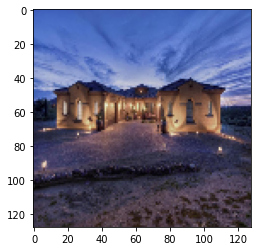

In [13]:
plt.imshow(images[8, 2][...,::-1])

In [14]:
X_train, X_test, images_train, images_test, y_train, y_test = train_test_split(X, images, y, test_size=0.15)

In [15]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Input, concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [27]:
inps = [Input(shape=(128, 128, 3)) for i in range(4)]


l = [[] for i in range(4)]
for i in range(4):

  l[i].append(Conv2D(32, (31, 31), padding='same', activation='relu')(inps[i]))
  l[i].append(MaxPool2D()(l[i][-1]))

  l[i].append(Conv2D(64, (15, 15), padding='same', activation='relu')(l[i][-1]))
  l[i].append(MaxPool2D()(l[i][-1]))

  l[i].append(Conv2D(64, (7, 7), padding='same', activation='relu')(l[i][-1]))
  l[i].append(MaxPool2D()(l[i][-1]))

  l[i].append(Conv2D(64, (3, 3), padding='same', activation='relu')(l[i][-1]))
  l[i].append(MaxPool2D()(l[i][-1]))

conc1 = concatenate([p[-1] for p in l])

conv5 = Conv2D(64, (3, 3), activation='relu')(conc1)
pool5 = MaxPool2D()(conv5)

flat1 = Flatten()(pool5)

dense1 = Dense(128, activation='sigmoid')(flat1)


In [28]:
m1 = Model(inputs=inps, outputs=dense1)


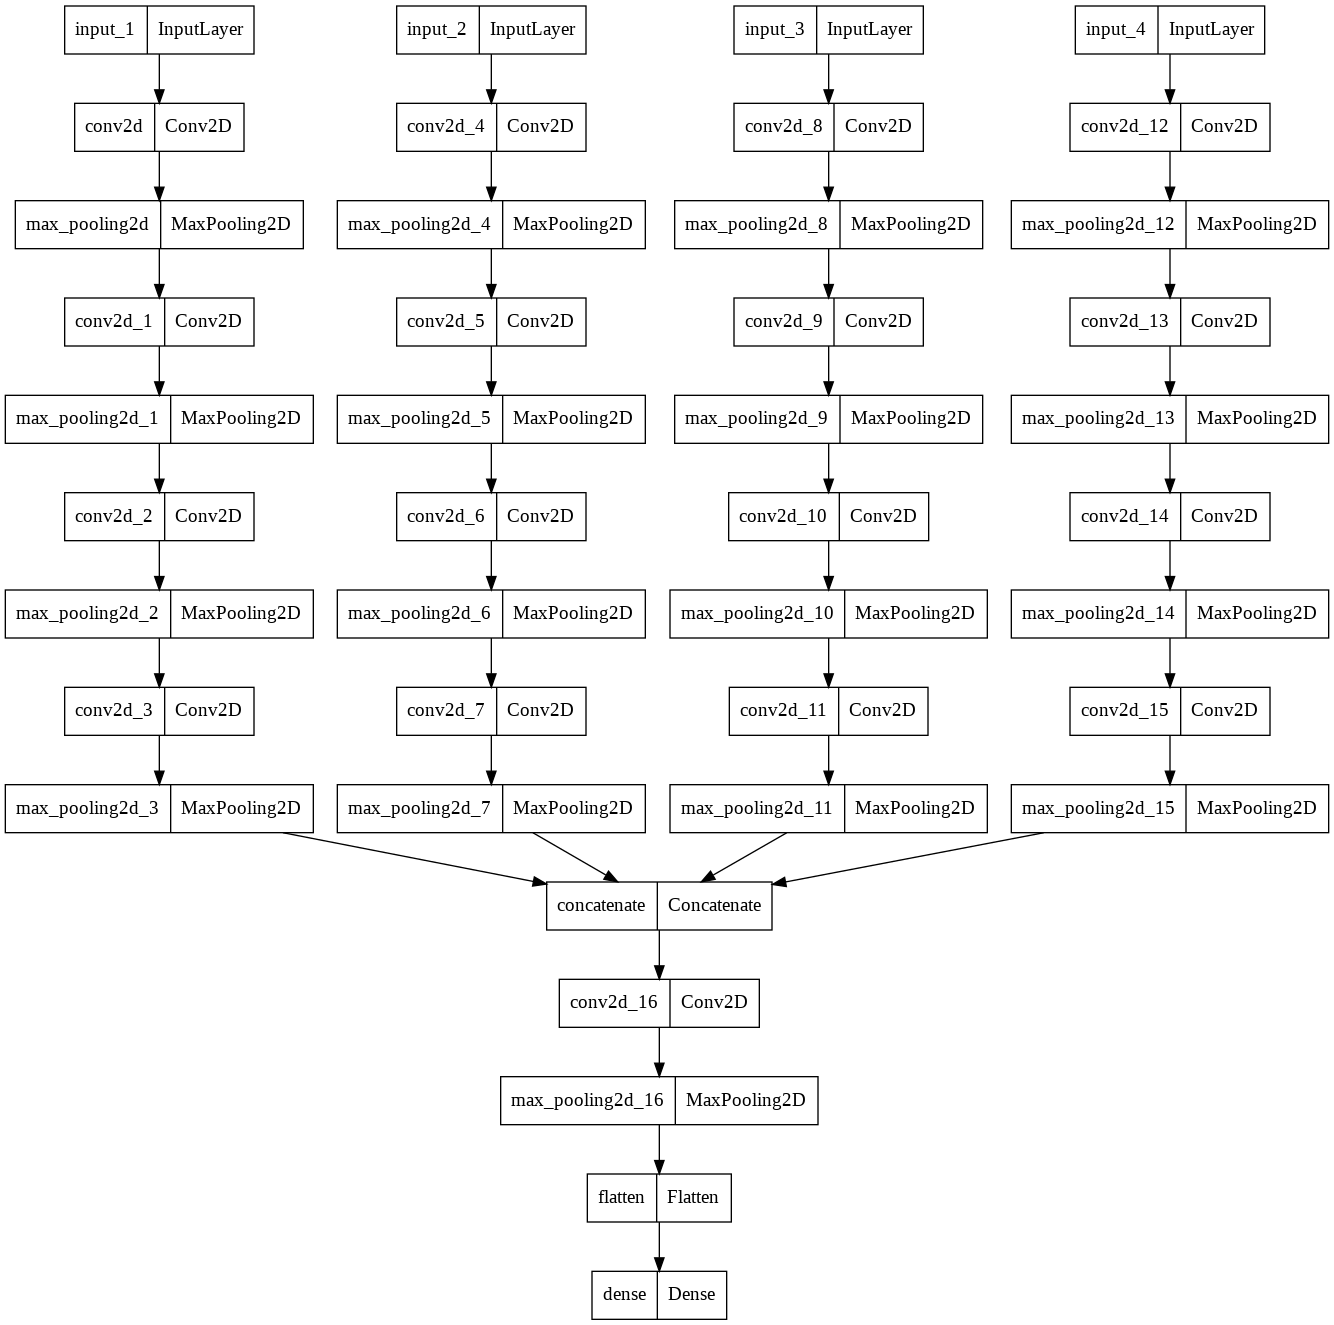

In [29]:
plot_model(m1)

In [30]:
m1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                            

In [31]:
m2 = Sequential([
                 Dense(64, activation='linear', input_dim=52),
                 Dense(128, activation='linear')
])

In [32]:
m2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                3392      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
Total params: 11,712
Trainable params: 11,712
Non-trainable params: 0
_________________________________________________________________


In [33]:
conc_models = concatenate([m1.output, m2.output])
dense2 = Dense(128, activation='linear')(conc_models)
output_layer = Dense(1, activation='linear')(dense2)

In [34]:
model = Model(inputs=[m1.input, m2.input], outputs=output_layer)

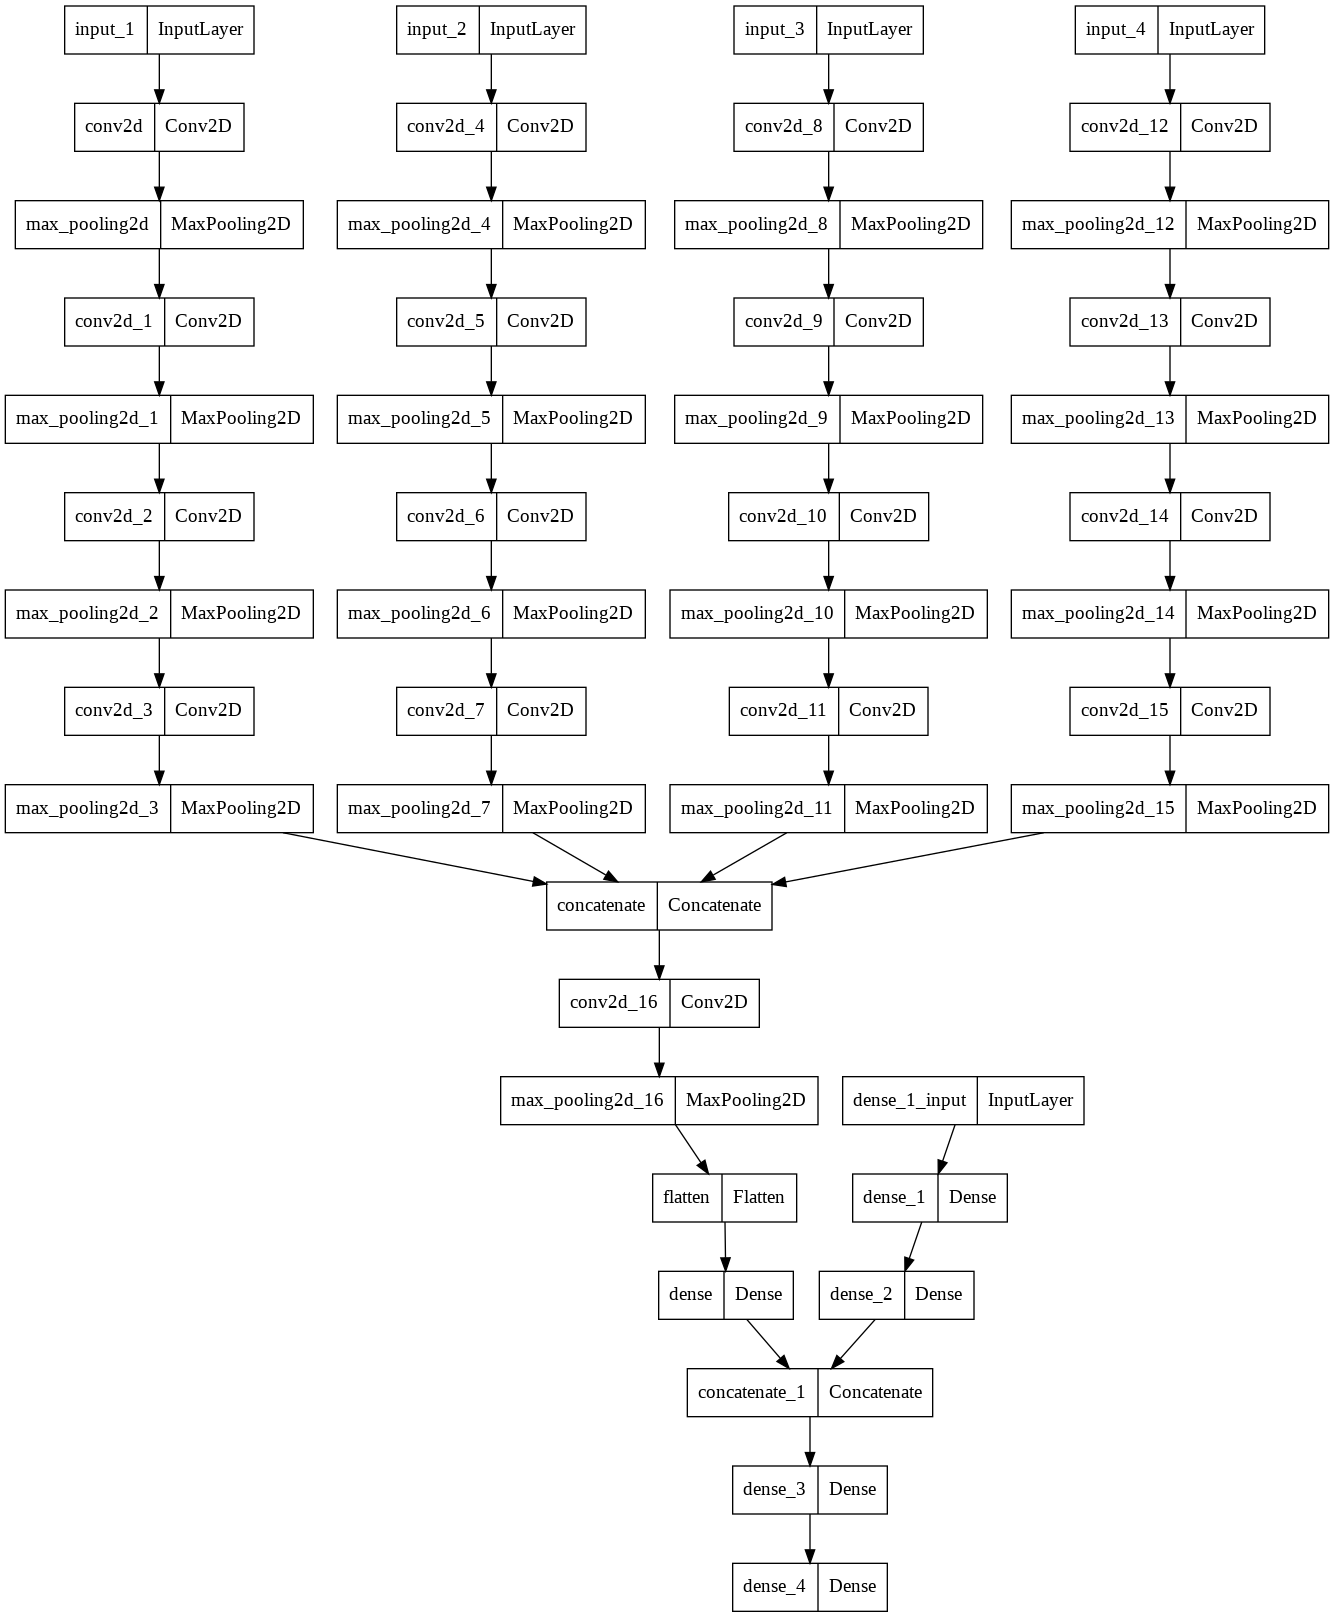

In [35]:
plot_model(model)

In [36]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                          

In [37]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [100]:
mchp = ModelCheckpoint('drive/MyDrive/datasets/housesPrice.h5', save_best_only=True)

In [108]:
model.fit(
    [images_train[:, i, ::] for i in range(4)]+[X_train], y_train,
     validation_data=([images_test[:, i, ::] for i in range(4)]+[X_test], y_test),
     epochs=400, batch_size=10, callbacks=[mchp]
     )

Epoch 1/400
46/46 [==============================] - 5s 103ms/step - loss: 0.0084 - val_loss: 0.0051
Epoch 2/400
46/46 [==============================] - 4s 97ms/step - loss: 0.0065 - val_loss: 0.0077
Epoch 3/400
46/46 [==============================] - 4s 97ms/step - loss: 0.0075 - val_loss: 0.0051
Epoch 4/400
46/46 [==============================] - 4s 97ms/step - loss: 0.0179 - val_loss: 0.0290
Epoch 5/400
46/46 [==============================] - 4s 98ms/step - loss: 0.0141 - val_loss: 0.0255
Epoch 6/400
46/46 [==============================] - 4s 98ms/step - loss: 0.0117 - val_loss: 0.0045
Epoch 7/400
46/46 [==============================] - 4s 98ms/step - loss: 0.0066 - val_loss: 0.0037
Epoch 8/400
46/46 [==============================] - 4s 98ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 9/400
46/46 [==============================] - 5s 98ms/step - loss: 0.0064 - val_loss: 0.0098
Epoch 10/400
46/46 [==============================] - 5s 98ms/step - loss: 0.0068 - val_loss: 0.004

In [16]:
from tensorflow.keras.models import load_model

In [17]:
model = load_model('drive/MyDrive/datasets/housesPrice.h5')

In [23]:
y_pred = model.predict([images_test[:, i, ::] for i in range(4)]+[X_test])

In [25]:
np.mean(np.abs(y_pred.flatten() - y_test) * max_price)

152382.32540652764

In [26]:
np.mean(y_test) * max_price

623344.8518518519